In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38675,2022-03-01T21:22:14.615Z,60.952300,-151.257700,0.00,2.20,ml,NaN,NaN,NaN,0.9100,...,2022-03-01T21:26:42.710Z,"14 km SSW of Tyonek, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
38676,2022-03-01T21:16:45.780Z,39.425333,-110.319667,-1.21,1.42,md,5.0,192.00,0.004385,0.0400,...,2022-03-01T22:46:44.500Z,"15 km SSE of Sunnyside, Utah",earthquake,1.33,0.22,0.212,4.0,reviewed,uu,uu
38677,2022-03-01T21:08:58.910Z,38.835167,-122.800003,2.22,0.85,md,11.0,77.00,0.008209,0.0100,...,2022-03-01T21:26:18.107Z,"7km WNW of Cobb, CA",earthquake,0.40,0.90,NaN,1.0,automatic,nc,nc
38678,2022-03-31T21:00:50.670Z,38.821499,-122.793167,3.21,0.35,md,10.0,90.00,0.012760,0.0100,...,2022-03-31T21:02:26.715Z,"6km NNW of The Geysers, CA",earthquake,0.63,1.10,NaN,1.0,automatic,nc,nc


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38675,2022-03-01 21:22:14.615000+00:00,60.952300,-151.257700,0.00,2.20,ml,NaN,NaN,NaN,0.9100,...,2022-03-01T21:26:42.710Z,"14 km SSW of Tyonek, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
38676,2022-03-01 21:16:45.780000+00:00,39.425333,-110.319667,-1.21,1.42,md,5.0,192.00,0.004385,0.0400,...,2022-03-01T22:46:44.500Z,"15 km SSE of Sunnyside, Utah",earthquake,1.33,0.22,0.212,4.0,reviewed,uu,uu
38677,2022-03-01 21:08:58.910000+00:00,38.835167,-122.800003,2.22,0.85,md,11.0,77.00,0.008209,0.0100,...,2022-03-01T21:26:18.107Z,"7km WNW of Cobb, CA",earthquake,0.40,0.90,NaN,1.0,automatic,nc,nc
38678,2022-03-31 21:00:50.670000+00:00,38.821499,-122.793167,3.21,0.35,md,10.0,90.00,0.012760,0.0100,...,2022-03-31T21:02:26.715Z,"6km NNW of The Geysers, CA",earthquake,0.63,1.10,NaN,1.0,automatic,nc,nc


In [5]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource


In [6]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag
0,37.384000,-117.107500,1.10,1.30
1,38.181000,-117.818000,7.30,1.40
2,61.340700,-149.885200,30.00,1.50
3,62.870300,-150.762500,111.30,2.10
4,64.014500,-148.765700,1.90,1.50
...,...,...,...,...
38675,60.952300,-151.257700,0.00,2.20
38676,39.425333,-110.319667,-1.21,1.42
38677,38.835167,-122.800003,2.22,0.85
38678,38.821499,-122.793167,3.21,0.35


In [7]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
dtype: int64

In [8]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [9]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [10]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['mag'], axis = 1)

y = cleaned_df_dropped[['mag']]

In [11]:
#checking number of columns and rows for each feature
X.shape, y.shape

((38674, 3), (38674, 1))

In [13]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [14]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 0.34620424777061387, 	R2 score: 0.7945424588811056, 	Model score: 0.7945424588811056
n_estimators=3:
	Mean Squared Error: 0.3088959315479237, 	R2 score: 0.8166833625926018, 	Model score: 0.8166833625926018
n_estimators=4:
	Mean Squared Error: 0.297085515339061, 	R2 score: 0.8236923438211378, 	Model score: 0.8236923438211378
n_estimators=5:
	Mean Squared Error: 0.28684294412323674, 	R2 score: 0.829770875526886, 	Model score: 0.829770875526886
n_estimators=6:
	Mean Squared Error: 0.2795917641563774, 	R2 score: 0.8340741433689046, 	Model score: 0.8340741433689046
n_estimators=7:
	Mean Squared Error: 0.2754769563416368, 	R2 score: 0.8365161073287274, 	Model score: 0.8365161073287274
n_estimators=8:
	Mean Squared Error: 0.27166025351219913, 	R2 score: 0.8387811586201759, 	Model score: 0.8387811586201759
n_estimators=9:
	Mean Squared Error: 0.2686272155943856, 	R2 score: 0.8405811380159436, 	Model score: 0.8405811380159436
n_estimators=10:
	Mean Squared E

In [15]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 0.34620424777061387, 	R2: 0.7945424588811056, 	Model score: 0.7945424588811056
n_estimators=3:
	Mean Squared Error: 0.3088959315479237, 	R2: 0.8166833625926018, 	Model score: 0.8166833625926018
n_estimators=4:
	Mean Squared Error: 0.297085515339061, 	R2: 0.8236923438211378, 	Model score: 0.8236923438211378
n_estimators=5:
	Mean Squared Error: 0.28684294412323674, 	R2: 0.829770875526886, 	Model score: 0.829770875526886
n_estimators=6:
	Mean Squared Error: 0.2795917641563774, 	R2: 0.8340741433689046, 	Model score: 0.8340741433689046
n_estimators=7:
	Mean Squared Error: 0.2754769563416368, 	R2: 0.8365161073287274, 	Model score: 0.8365161073287274
n_estimators=8:
	Mean Squared Error: 0.27166025351219913, 	R2: 0.8387811586201759, 	Model score: 0.8387811586201759
n_estimators=9:
	Mean Squared Error: 0.2686272155943856, 	R2: 0.8405811380159436, 	Model score: 0.8405811380159436
n_estimators=10:
	Mean Squared Error: 0.26646935308005915, 	R2: 0.84186173791938

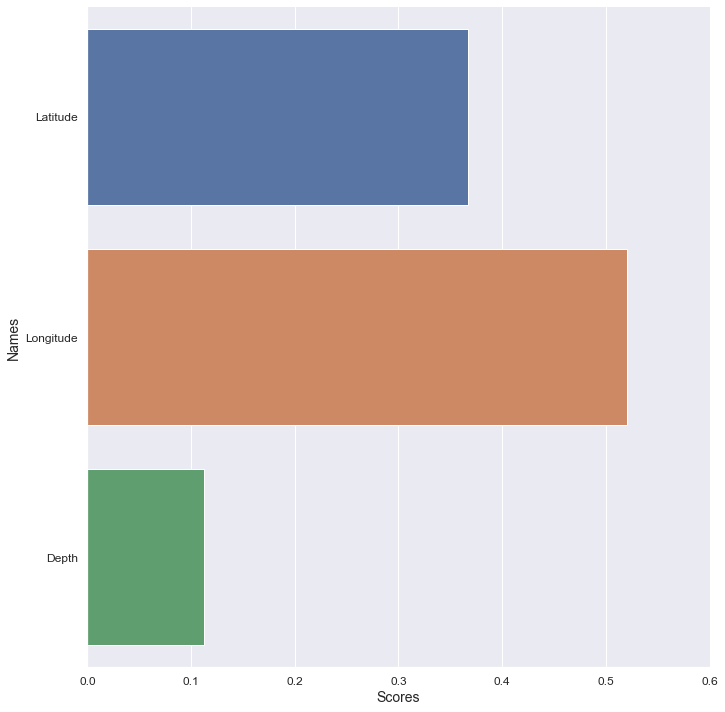

In [16]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['latitude', 'longitude', 'depth']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [17]:
#define number of splits for cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 3868  3869  3870 ... 38671 38672 38673] | test: [   0    1    2 ... 3865 3866 3867]
Train: [    0     1     2 ... 38671 38672 38673] | test: [3868 3869 3870 ... 7733 7734 7735]
Train: [    0     1     2 ... 38671 38672 38673] | test: [ 7736  7737  7738 ... 11601 11602 11603]
Train: [    0     1     2 ... 38671 38672 38673] | test: [11604 11605 11606 ... 15469 15470 15471]
Train: [    0     1     2 ... 38671 38672 38673] | test: [15472 15473 15474 ... 19336 19337 19338]
Train: [    0     1     2 ... 38671 38672 38673] | test: [19339 19340 19341 ... 23203 23204 23205]
Train: [    0     1     2 ... 38671 38672 38673] | test: [23206 23207 23208 ... 27070 27071 27072]
Train: [    0     1     2 ... 38671 38672 38673] | test: [27073 27074 27075 ... 30937 30938 30939]
Train: [    0     1     2 ... 38671 38672 38673] | test: [30940 30941 30942 ... 34804 34805 34806]
Train: [    0     1     2 ... 34804 34805 34806] | test: [34807 34808 34809 ... 38671 38672 38673]


In [18]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-0.37107988 -0.3731518  -0.36011307 -0.38059296 -0.37537964 -0.36346889
 -0.36997503 -0.3809831  -0.36779019 -0.35518323]
MAE: -0.370 (0.008)


In [19]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [20]:
##create elements for plot validation curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

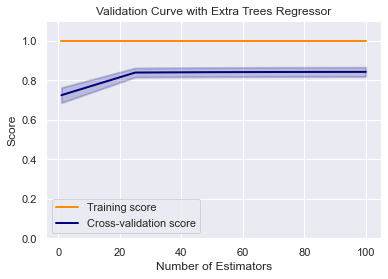

In [21]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [22]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_mag = y_test
mags = actual_mag['mag'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(mags, testpredict)
test_mse = mean_squared_error(y_test, testpred)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 0.500
MAE: 0.365


In [23]:
#make dataframe with actual test values and ML predicted ones
mag_pred = actual_mag
mag_pred['Predicted'] = testpredict


In [24]:
mag_pred_all = mag_pred.rename(columns={'mag': 'Actual'})
mag_pred_all

,Actual,Predicted
31109,3.30,3.4640
27837,1.58,1.1138
5591,1.60,2.4901
21969,4.60,4.3980
35589,2.09,2.3515
...,...,...
3822,2.50,2.7297
6029,0.12,0.5311
28514,1.99,2.0929
29955,2.75,1.6326


In [25]:
#join dataframes for actual and predicted with original dataframe
mag_pred_all = mag_pred.merge(model_df, how='inner', left_index=True, right_index=True)
mag_pred_all


,mag_x,Predicted,time,latitude,longitude,depth,mag_y,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
31109,3.30,3.4640,2022-03-25 16:00:55.679000+00:00,56.351600,-148.781200,10.00,3.30,ml,NaN,251.0,...,2022-03-25T17:58:29.040Z,"254 km SE of Chiniak, Alaska",earthquake,10.80,2.00,0.057000,40.0,reviewed,us,us
27837,1.58,1.1138,2022-02-19 14:10:13.970000+00:00,38.771333,-122.710167,1.84,1.58,md,26.0,72.0,...,2022-02-20T00:36:10.812Z,"2km WSW of Anderson Springs, CA",earthquake,0.25,0.22,0.002000,2.0,reviewed,nc,nc
5591,1.60,2.4901,2021-12-16 17:25:21.244000+00:00,54.649600,-163.397900,25.40,1.60,ml,NaN,NaN,...,2021-12-24T18:51:05.622Z,"Unimak Island region, Alaska",earthquake,NaN,1.40,NaN,NaN,reviewed,ak,ak
21969,4.60,4.3980,2022-02-10 13:20:40.227000+00:00,-6.497700,129.931000,150.46,4.60,mb,NaN,41.0,...,2022-02-18T19:05:47.040Z,Banda Sea,earthquake,8.60,8.60,0.110000,25.0,reviewed,us,us
35589,2.09,2.3515,2022-03-11 15:03:17.330000+00:00,34.229167,-80.543000,1.19,2.09,md,10.0,87.0,...,2022-03-27T21:47:58.104Z,"6 km ESE of Camden, South Carolina",earthquake,0.63,3.18,0.014000,5.0,reviewed,se,se
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,2.50,2.7297,2021-12-21 21:46:46.811000+00:00,44.367600,-115.153500,10.00,2.50,ml,NaN,61.0,...,2021-12-22T10:07:34.472Z,"23 km NW of Stanley, Idaho",earthquake,2.40,2.00,0.059000,38.0,reviewed,us,us
6029,0.12,0.5311,2021-12-15 09:49:26.220000+00:00,33.587167,-116.805000,7.89,0.12,ml,12.0,160.0,...,2021-12-15T16:11:54.925Z,"13km WNW of Anza, CA",earthquake,0.23,0.33,0.102000,5.0,reviewed,ci,ci
28514,1.99,2.0929,2022-02-17 21:00:20.390000+00:00,19.332500,-155.164333,5.01,1.99,md,42.0,85.0,...,2022-02-18T04:05:28.130Z,"14 km SSE of Volcano, Hawaii",earthquake,0.28,0.76,0.142247,21.0,reviewed,hv,hv
29955,2.75,1.6326,2022-03-29 12:41:40.700000+00:00,19.508500,-155.677000,5.11,2.75,ml,16.0,142.0,...,2022-03-29T13:44:57.690Z,"20 km ENE of Honaunau-Napoopoo, Hawaii",earthquake,0.54,0.81,0.159620,12.0,reviewed,hv,hv


In [26]:
#rename columns
mag_pred_all = mag_pred_all.rename(columns={'mag_x': 'Actual', 'mag_y': 'mag'})
mag_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
31109,3.30,3.4640,2022-03-25 16:00:55.679000+00:00,56.351600,-148.781200,10.00,3.30,ml,NaN,251.0,...,2022-03-25T17:58:29.040Z,"254 km SE of Chiniak, Alaska",earthquake,10.80,2.00,0.057000,40.0,reviewed,us,us
27837,1.58,1.1138,2022-02-19 14:10:13.970000+00:00,38.771333,-122.710167,1.84,1.58,md,26.0,72.0,...,2022-02-20T00:36:10.812Z,"2km WSW of Anderson Springs, CA",earthquake,0.25,0.22,0.002000,2.0,reviewed,nc,nc
5591,1.60,2.4901,2021-12-16 17:25:21.244000+00:00,54.649600,-163.397900,25.40,1.60,ml,NaN,NaN,...,2021-12-24T18:51:05.622Z,"Unimak Island region, Alaska",earthquake,NaN,1.40,NaN,NaN,reviewed,ak,ak
21969,4.60,4.3980,2022-02-10 13:20:40.227000+00:00,-6.497700,129.931000,150.46,4.60,mb,NaN,41.0,...,2022-02-18T19:05:47.040Z,Banda Sea,earthquake,8.60,8.60,0.110000,25.0,reviewed,us,us
35589,2.09,2.3515,2022-03-11 15:03:17.330000+00:00,34.229167,-80.543000,1.19,2.09,md,10.0,87.0,...,2022-03-27T21:47:58.104Z,"6 km ESE of Camden, South Carolina",earthquake,0.63,3.18,0.014000,5.0,reviewed,se,se
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,2.50,2.7297,2021-12-21 21:46:46.811000+00:00,44.367600,-115.153500,10.00,2.50,ml,NaN,61.0,...,2021-12-22T10:07:34.472Z,"23 km NW of Stanley, Idaho",earthquake,2.40,2.00,0.059000,38.0,reviewed,us,us
6029,0.12,0.5311,2021-12-15 09:49:26.220000+00:00,33.587167,-116.805000,7.89,0.12,ml,12.0,160.0,...,2021-12-15T16:11:54.925Z,"13km WNW of Anza, CA",earthquake,0.23,0.33,0.102000,5.0,reviewed,ci,ci
28514,1.99,2.0929,2022-02-17 21:00:20.390000+00:00,19.332500,-155.164333,5.01,1.99,md,42.0,85.0,...,2022-02-18T04:05:28.130Z,"14 km SSE of Volcano, Hawaii",earthquake,0.28,0.76,0.142247,21.0,reviewed,hv,hv
29955,2.75,1.6326,2022-03-29 12:41:40.700000+00:00,19.508500,-155.677000,5.11,2.75,ml,16.0,142.0,...,2022-03-29T13:44:57.690Z,"20 km ENE of Honaunau-Napoopoo, Hawaii",earthquake,0.54,0.81,0.159620,12.0,reviewed,hv,hv


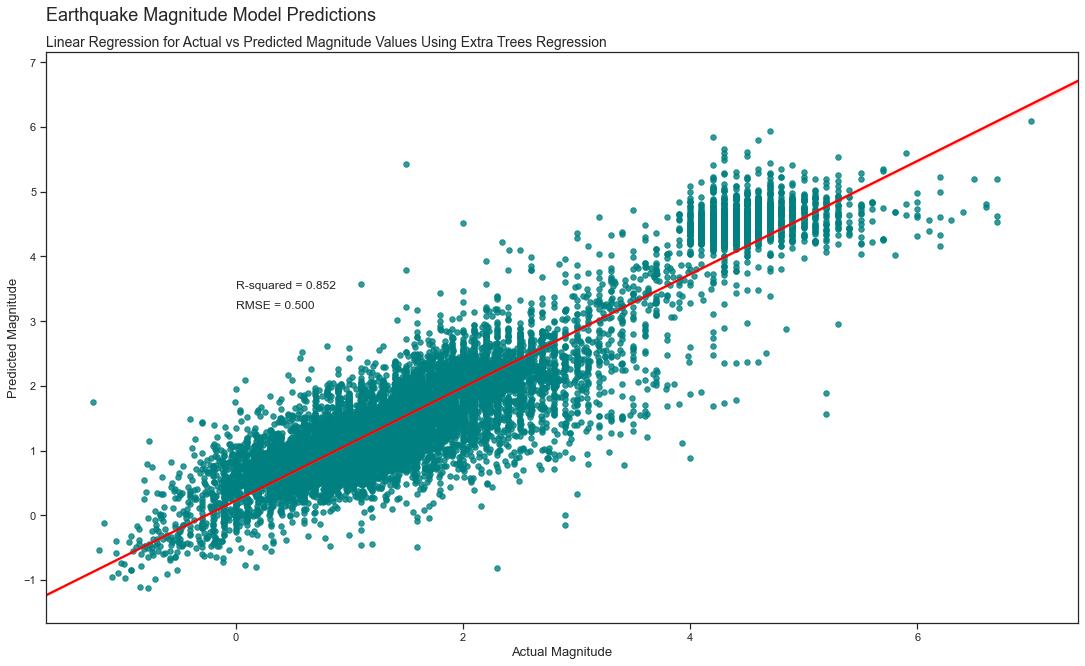

In [27]:
#plot actual vs predicted values
x = np.array(mag_pred_all['mag'])
y = np.array(testpredict)


sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Magnitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(mag_pred_all['mag'], testpredict)), (0, 3.5),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 3.2), fontsize=12)

fig.savefig('../static/images/extratrees_magnotime_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [28]:
# make a single prediction
from datetime import datetime
lat = float(input('Enter a latitude (in decimal form; negative for southern hemisphere): '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
# date_input = input('Enter a date (yyyy/mm/dd): ')
# time_input = input('Enter a time in UTC: ')
# datetime_str = date_input + ' '+ time_input
# date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
# date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[lat,lon,depth]]
y_pred = best_model.predict(single_features)
print('Predicted Magnitude: %g' % y_pred)

Predicted Magnitude: 6.3


Test with new data from USGS

In [29]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-31T21:28:21.250Z,38.814499,-122.819000,2.86,0.84,md,10.0,81.0,0.009739,0.01,...,2022-03-31T21:29:57.505Z,"7km NW of The Geysers, CA",earthquake,0.44,0.93,NaN,1.0,automatic,nc,nc
1,2022-03-31T21:25:02.450Z,19.174166,-155.475174,33.09,2.29,ml,44.0,78.0,NaN,0.15,...,2022-03-31T21:30:31.060Z,"3 km S of Pāhala, Hawaii",earthquake,0.56,0.78,2.550000,12.0,automatic,hv,hv
2,2022-03-31T21:12:20.740Z,37.411500,-118.602000,10.24,1.46,md,24.0,61.0,0.065900,0.06,...,2022-03-31T21:31:28.203Z,"0km SW of Round Valley, CA",earthquake,0.31,0.86,0.124000,18.0,reviewed,nc,nc
3,2022-03-31T21:00:50.670Z,38.821499,-122.793167,3.21,0.35,md,10.0,90.0,0.012760,0.01,...,2022-03-31T21:17:25.705Z,"6km NNW of The Geysers, CA",earthquake,0.63,1.10,NaN,1.0,automatic,nc,nc
4,2022-03-31T20:55:28.240Z,37.408667,-118.627500,5.96,0.78,md,8.0,165.0,0.075420,0.01,...,2022-03-31T21:22:57.178Z,"3km WSW of Round Valley, CA",earthquake,0.91,2.03,0.196000,9.0,reviewed,nc,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2022-03-30T21:54:04.873Z,57.455300,-154.790600,0.00,2.30,ml,NaN,NaN,NaN,0.78,...,2022-03-30T21:56:39.623Z,"23 km WSW of Karluk, Alaska",earthquake,NaN,0.70,NaN,NaN,automatic,ak,ak
255,2022-03-30T21:40:33.030Z,17.824000,-66.868333,8.02,2.10,md,6.0,262.0,NaN,0.14,...,2022-03-30T22:13:51.080Z,"16 km SSE of Guánica, Puerto Rico",earthquake,0.86,13.22,0.090393,6.0,reviewed,pr,pr
256,2022-03-30T21:39:24.390Z,19.414333,-155.608167,-2.23,0.64,md,10.0,116.0,NaN,0.10,...,2022-03-31T01:32:32.330Z,"27 km NNW of Pāhala, Hawaii",earthquake,0.24,0.31,0.085468,6.0,reviewed,hv,hv
257,2022-03-30T21:33:55.208Z,61.091200,-148.025400,21.40,1.70,ml,NaN,NaN,NaN,0.59,...,2022-03-30T21:53:04.284Z,"50 km NE of Whittier, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak


In [30]:
#dropped columns not needed
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df

,latitude,longitude,depth,mag
0,38.814499,-122.819000,2.86,0.84
1,19.174166,-155.475174,33.09,2.29
2,37.411500,-118.602000,10.24,1.46
3,38.821499,-122.793167,3.21,0.35
4,37.408667,-118.627500,5.96,0.78
...,...,...,...,...
254,57.455300,-154.790600,0.00,2.30
255,17.824000,-66.868333,8.02,2.10
256,19.414333,-155.608167,-2.23,0.64
257,61.091200,-148.025400,21.40,1.70


In [31]:
#find if any column has NaNs
cleaned_test_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [32]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['mag'], axis = 1)

y_test_data = cleaned_test_df[['mag']]

In [33]:
#use best model to predict data
pred_data_y = best_model.predict(X_test_data)


In [34]:
#create dataframe with predicted values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data

,latitude,longitude,depth,mag,Predicted
0,38.814499,-122.819000,2.86,0.84,0.7025
1,19.174166,-155.475174,33.09,2.29,2.1570
2,37.411500,-118.602000,10.24,1.46,1.0868
3,38.821499,-122.793167,3.21,0.35,0.5751
4,37.408667,-118.627500,5.96,0.78,1.3424
...,...,...,...,...,...
254,57.455300,-154.790600,0.00,2.30,2.3000
255,17.824000,-66.868333,8.02,2.10,2.1000
256,19.414333,-155.608167,-2.23,0.64,1.5682
257,61.091200,-148.025400,21.40,1.70,1.7000


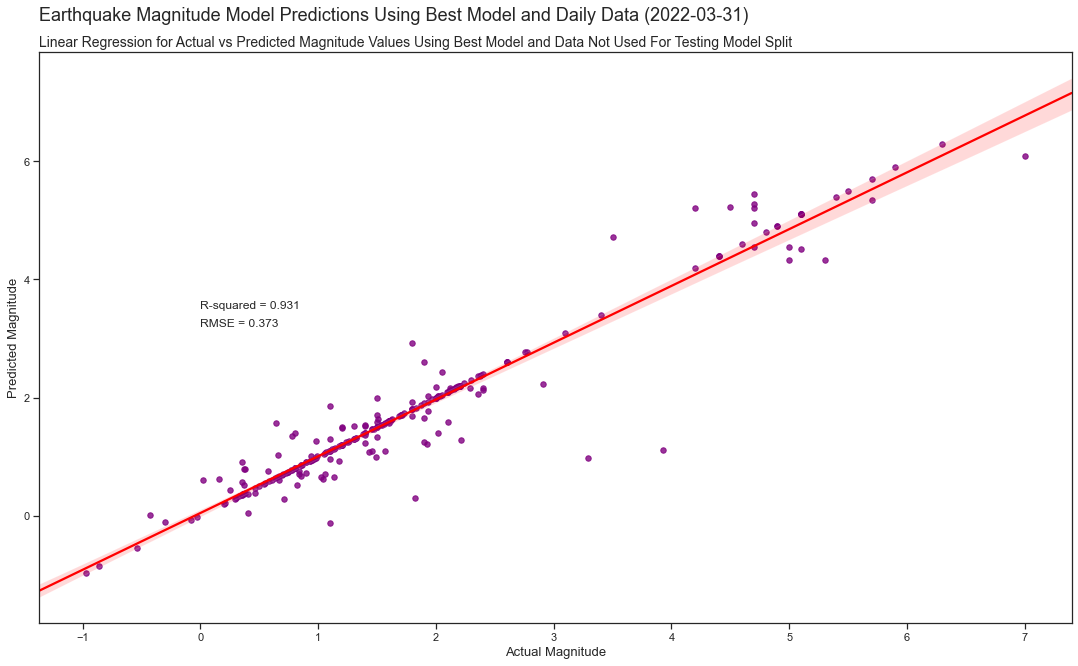

In [35]:
#create grpah for actual vs predicted values
from datetime import date
today = date.today()

x = np.array(test_pred_data['mag'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Magnitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 3.5),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 3.2), fontsize=12)

fig.savefig('../static/images/extratrees_magnotime_linear_sns_daily.png', bbox_inches='tight',dpi=600)
plt.show()

In [36]:
#create new tables in database with training/test dataset test values and predictions

#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
mag_pred_all.to_sql('earthquake_etrees_mag_notime', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
mag_pred_all.to_sql('earthquake_etrees_mag_notime', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()

Connected to database...
